# Review Post Attributes Models

This notebook builds a range of machine learning models to predict a user's sentiment based upon various review post attributes.

* Section 1 - Import libraries and dataset
* Section 2 - Pre-processing and feature engineering
* Section 3 - Base models


Features:
* User Contributions
* Town
* Category
* Date of review
* Location of user
* Outlet type
* Cuisine type


# Section 1: Import Libraries and Dataset

In [ ]:
#!pip install -U imbalanced-learn

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2,RFECV,VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score,learning_curve
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, balanced_accuracy_score
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_recall_curve,plot_precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,fbeta_score,f1_score

import warnings
warnings.filterwarnings("ignore")

In [51]:
# Read in dataset from MScExploratory Data Analysis Part One
df = pd.read_csv("models1.csv",index_col = 0)

In [52]:
df.head(2)

,Name,Category,Town,Type,Contributions,Title,Review,Rating,Date,LocCode,Cuisine
0,Norfolk Arms,Accommodation,Arundel,Hotel,1278,Great value in the heart of arundel,Booked a room to stay the night in Arundel. Th...,4,4.0,2.0,0
1,Town House,Accommodation,Arundel,B&B/Inn,1163,"Excellent food,service and ambience!",We’ve eaten here with a group of friends who g...,5,4.0,2.0,0


In [53]:
df.shape

(7947, 11)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7947 entries, 0 to 7946
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           7947 non-null   object 
 1   Category       7947 non-null   object 
 2   Town           7947 non-null   object 
 3   Type           7947 non-null   object 
 4   Contributions  7947 non-null   int64  
 5   Title          7947 non-null   object 
 6   Review         7947 non-null   object 
 7   Rating         7947 non-null   int64  
 8   Date           7947 non-null   float64
 9   LocCode        7947 non-null   float64
 10  Cuisine        7947 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 745.0+ KB


# Section 2: Preprocessing and Feature Engineering

### Combine Type categories for simplification

In [55]:
# Get cuisine types
df["Cuisine"].value_counts()

0                2784
British          2769
Other             852
Italian/Pizza     449
Seafood           362
Indian            361
Chinese/Thai      216
American          152
International       2
Name: Cuisine, dtype: int64

In [56]:
# Strip whitespace from Type column
df.Type = df.Type.str.strip()

In [57]:
# Combine categories to simplify model
df["Cuisine"] = df["Cuisine"].replace(["Chinese/Thai","Indian"],"Asian/Oriental")
df["Cuisine"] = df["Cuisine"].replace(["Seafood","American","n/a"],["British","Other","Not Specified"])

In [58]:
# Combine food outlets to simplify model
df["Type"] = df["Type"].replace(["Steakhouse/Diner","Gastropub"],["Restaurant","Pub/Bar"])

### Set Ratings to Binary

In [59]:
# Create new column for Score and set binary values for ratings
df["Score"] = df["Rating"]
df = df[df["Rating"] != 3]
df.Score.replace([1,2], 1, inplace = True)
df.Score.replace([4,5], 0, inplace = True)
df.drop(columns = ["Rating"],axis = 1, inplace = True)

In [60]:
df.head(2)

,Name,Category,Town,Type,Contributions,Title,Review,Date,LocCode,Cuisine,Score
0,Norfolk Arms,Accommodation,Arundel,Hotel,1278,Great value in the heart of arundel,Booked a room to stay the night in Arundel. Th...,4.0,2.0,0,0
1,Town House,Accommodation,Arundel,B&B/Inn,1163,"Excellent food,service and ambience!",We’ve eaten here with a group of friends who g...,4.0,2.0,0,0


### Balancing The Dataset By Sampling

In [61]:
# Split into category dataframes
accom = df[df["Category"] == "Accommodation"]
food = df[df["Category"] == "Food"]
attract = df[df["Category"] == "Attractions"]

In [62]:
# Get ratings split between 0 and 1 for each category
print(accom.Score.value_counts())
print(food.Score.value_counts())
print(attract.Score.value_counts())

0    1388
1     208
Name: Score, dtype: int64
0    4060
1     664
Name: Score, dtype: int64
0    887
1     37
Name: Score, dtype: int64


In [63]:
# Function to get balanced sample based on ratings for each dataframe
def sampling(df,sample_size):
    sampled_good = df[df["Score"] == 0].sample(sample_size)
    sampled_bad = df[df["Score"] == 1]
    new_df = sampled_good.append(sampled_bad)
    new_df = new_df.sample(frac=1).reset_index(drop=True)
    return new_df

In [64]:
# Run function - random sampling same number of zero rated reviews to match those rated 1 to create balanced datasets
accom_balanced = sampling(accom,accom.Score.value_counts()[1])
food_balanced = sampling(food,food.Score.value_counts()[1])
attract_balanced = sampling(attract,attract.Score.value_counts()[1])

In [65]:
# Get value counts of scores for each dataframe
print(accom_balanced["Score"].value_counts())
print(food_balanced["Score"].value_counts())
print(attract_balanced["Score"].value_counts())

0    208
1    208
Name: Score, dtype: int64
0    664
1    664
Name: Score, dtype: int64
0    37
1    37
Name: Score, dtype: int64


### Train, Validation, Split 

In [66]:
# Function to split each balanced dataframe into training, validation and test splits with a stratified rating value
def splitting(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size=0.2, random_state=1)

    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test,test_size=0.50, random_state=1) 
    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [67]:
# Run function to get the train, validation and test splits for features and ratings for each category
X_train_accom,y_train_accom,X_val_accom,y_val_accom,X_test_accom,y_test_accom = splitting(accom_balanced.iloc[:,0:10],accom_balanced.Score)
X_train_food,y_train_food,X_val_food,y_val_food,X_test_food,y_test_food = splitting(food_balanced.iloc[:,0:10],food_balanced.Score)
X_train_attract,y_train_attract,X_val_attract,y_val_attract,X_test_attract,y_test_attract = splitting(attract_balanced.iloc[:,0:10],attract_balanced.Score)

In [68]:
# Print shape of training,valuation and test sets for each category - note attraction datasets are very small!
print(X_train_accom.shape,X_val_accom.shape,X_test_accom.shape)
print(X_train_food.shape,X_val_food.shape,X_test_food.shape)
print(X_train_attract.shape,X_val_attract.shape,X_test_attract.shape)

(332, 10) (42, 10) (42, 10)
(1062, 10) (133, 10) (133, 10)
(59, 10) (8, 10) (7, 10)


In [69]:
# Check ratings are balanced for training set as an example(val and test will also be balanced based on the function)
y_train_food.value_counts()

0    531
1    531
Name: Score, dtype: int64

### Recombine Data

In [70]:
# Recombine balanced features (X) into a single dataframe
combined_X_train = pd.DataFrame(X_train_accom.append([X_train_food,X_train_attract]))
combined_X_val = pd.DataFrame(X_val_accom.append([X_val_food,X_val_attract]))
combined_X_test = pd.DataFrame(X_test_accom.append([X_test_food,X_test_attract]))

In [71]:
# Recombine the ratings (y) into dataframes and shuffle
combined_y_train = pd.DataFrame(y_train_accom.append([y_train_food,y_train_attract]))
combined_y_val = pd.DataFrame(y_val_accom.append([y_val_food,y_val_attract]))
combined_y_test = pd.DataFrame(y_test_accom.append([y_test_food,y_test_attract]))

In [72]:
# Combine features and ratings into single dataframes for each category
combined_train_df = pd.concat([combined_X_train,combined_y_train],axis = 1)
combined_val_df = pd.concat([combined_X_val,combined_y_val],axis = 1)
combined_test_df = pd.concat([combined_X_test,combined_y_test],axis = 1)

In [73]:
# Size of balanced training dataset of reviews
combined_train_df.shape

(1453, 11)

In [74]:
combined_train_df.shape

(1453, 11)

In [75]:
combined_train_df.head(2)

,Name,Category,Town,Type,Contributions,Title,Review,Date,LocCode,Cuisine,Score
245,Trevali Buest House,Accommodation,Bognor,B&B/Inn,315,Central B & B,"We had room 6, excellent view, we could see th...",1.0,2.0,0,0
209,Sea View,Accommodation,Littlehampton,Hotel,50,Not what it used to be...,"We lived in the area for 25 years and in fact,...",2.0,2.0,0,1


In [76]:
combined_train_df.to_csv("combined_train.csv")
combined_val_df.to_csv("combined_val.csv")
combined_test_df.to_csv("combined_test.csv")

### Change Type, rescaling and Create Dummies

In [184]:
def change_funct(df):
    
    # Change type to category
    type_cols = ['Date', 'LocCode']
    df[type_cols] = df[type_cols].astype('category')
        
    # Rescale contributions column (standard scaler produces negative results so minmaxscaler is used)
    scaler = MinMaxScaler()
    df["Contributions"] = scaler.fit_transform(df[["Contributions"]])
    
    # Create dummies
    non_dummy_cols = ["Name","Contributions","Title","Review","Score"] 
    dummy_cols = list(set(combined_train_df.columns) - set(non_dummy_cols))
    df = pd.get_dummies(df, columns=dummy_cols, drop_first = True)
    return df

In [185]:
# Run function
df_train = change_funct(combined_train_df)
df_val = change_funct(combined_val_df)
df_test = change_funct(combined_test_df)

# Section 3: Feature Selection

In [102]:
df_train.head(2)

,Name,Contributions,Title,Review,Score,Date_2.0,Date_3.0,Date_4.0,Type_Amusements/Fun,Type_B&B/Inn,...,LocCode_2.0,LocCode_3.0,Category_Attractions,Category_Food,Cuisine_Asian/Oriental,Cuisine_British,Cuisine_Italian/Pizza,Cuisine_Other,Town_Bognor,Town_Littlehampton
245,Trevali Buest House,0.239362,Central B & B,"We had room 6, excellent view, we could see th...",0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
209,Sea View,0.037994,Not what it used to be...,"We lived in the area for 25 years and in fact,...",1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


<AxesSubplot:>

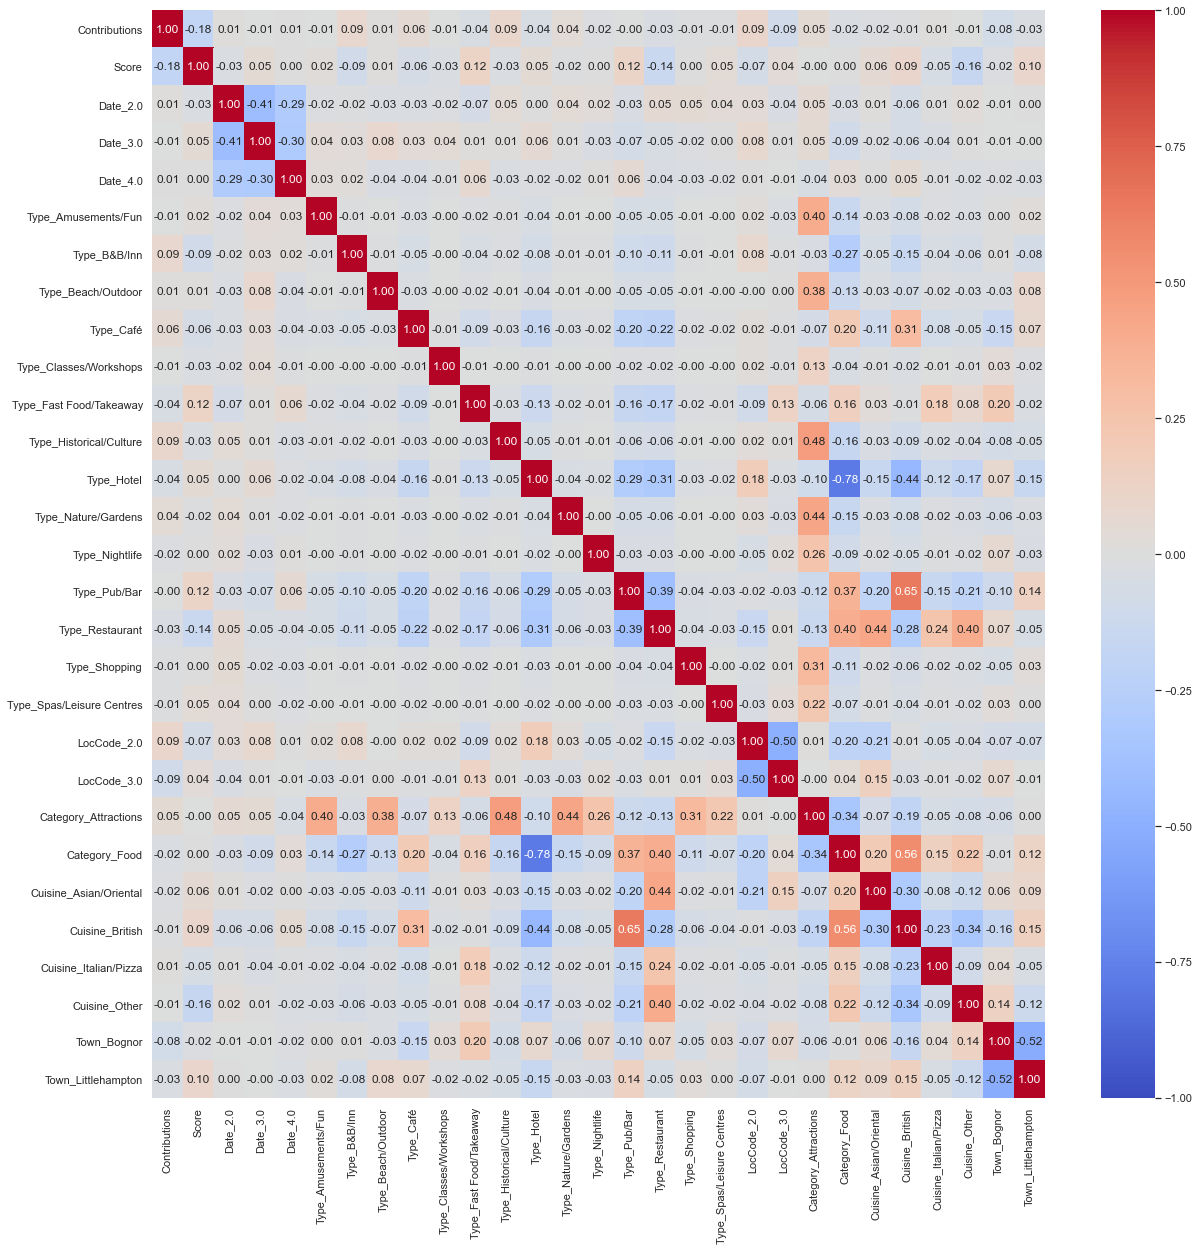

In [103]:
# Look at a heatmap
relevant_columns = df_train.drop(columns = ["Name","Title","Review"])
plt.figure(figsize=(20,20))
sns.heatmap(relevant_columns.corr(), annot = True, vmin=-1, cmap='coolwarm',fmt=".2f")
plt.plot()

In [223]:
# Define X (features) and y (target) from the newly rated dataframes

# Target variables
y_train = df_train["Score"]
y_val = df_val["Score"]
y_test = df_test["Score"]

# Features
X_train = df_train.drop(columns = ["Score","Name","Title","Review"], axis = 1)
X_val = df_val.drop(["Score","Name","Title","Review"],axis = 1)
X_test = df_test.drop(["Score","Name","Title","Review"], axis = 1)

## a) Select K-best Features - Categorical Variables Only

Feature 0: 0.934207
Feature 1: 2.735377
Feature 2: 0.018379
Feature 3: 0.402758
Feature 4: 11.890036
Feature 5: 0.112492
Feature 6: 5.060808
Feature 7: 0.998624
Feature 8: 20.938285
Feature 9: 1.137358
Feature 10: 3.399631
Feature 11: 0.330586
Feature 12: 0.000002
Feature 13: 14.638309
Feature 14: 19.754963
Feature 15: 0.000003
Feature 16: 3.004132
Feature 17: 2.487879
Feature 18: 1.642352
Feature 19: 0.015601
Feature 20: 0.000503
Feature 21: 4.530882
Feature 22: 7.016075
Feature 23: 3.832408
Feature 24: 32.791599
Feature 25: 0.383567
Feature 26: 9.482800


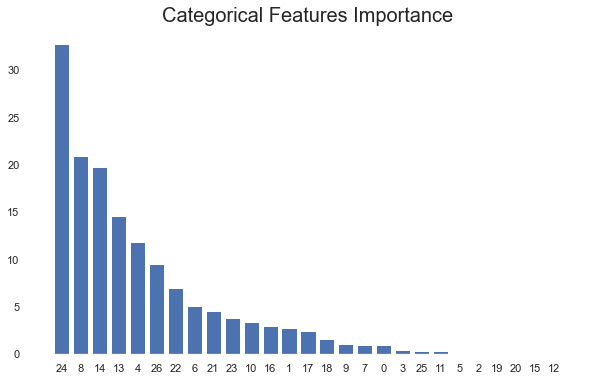

In [222]:
# Function to find the categorical features with the highest Chi squared value
X_train_cat = X_train.drop(columns = ["Contributions"])
chi2_selector = SelectKBest(chi2, k=10)
best = chi2_selector.fit(X_train_cat,y_train)
X_best = best.scores_
best_df = pd.DataFrame(X_best)
best_df = best_df.sort_values(by = 0,ascending = False)
best_df.columns = ["Scores"]
for i in range(len(best.scores_)):
    print('Feature %d: %f' % (i, best.scores_[i]))

fig, ax = plt.subplots(figsize = (10,6))
ax.set_facecolor("White")
plt.bar([i for i in range(len(best_df))], best_df.Scores)
plt.title("Categorical Features Importance", size = 20)
plt.xticks(range(0,27),best_df.index)
plt.show()

In [221]:
X_train_cat.columns

Index(['Date_2.0', 'Date_3.0', 'Date_4.0', 'Type_Amusements/Fun',
       'Type_B&B/Inn', 'Type_Beach/Outdoor', 'Type_Café',
       'Type_Classes/Workshops', 'Type_Fast Food/Takeaway',
       'Type_Historical/Culture', 'Type_Hotel', 'Type_Nature/Gardens',
       'Type_Nightlife', 'Type_Pub/Bar', 'Type_Restaurant', 'Type_Shopping',
       'Type_Spas/Leisure Centres', 'LocCode_2.0', 'LocCode_3.0',
       'Category_Attractions', 'Category_Food', 'Cuisine_Asian/Oriental',
       'Cuisine_British', 'Cuisine_Italian/Pizza', 'Cuisine_Other',
       'Town_Bognor', 'Town_Littlehampton'],
      dtype='object')

## b) Recursive Feature Elimination

In [165]:
# Recursive Feature Elimination using cross validation to eliminate features that don't contribute to accuracy
def recurse(model,X,y):
    rfecv = RFECV(estimator = model, step = 1, scoring = "accuracy")
    rfecv.fit(X,y)
    rfecv.transform(X)
    return rfecv

In [166]:
# Set up recursive elimnatinon model
result = recurse(LogisticRegression(random_state = 0),X_train,y_train)

In [167]:
# Print number of important features
result.n_features_

10

In [168]:
# Grid Scores
result.grid_scores_

array([0.58774499, 0.58430383, 0.59461074, 0.60152862, 0.60701742,
       0.60426354, 0.62492712, 0.63179524, 0.63592606, 0.63799739,
       0.61804953, 0.63661808, 0.62973575, 0.62834696, 0.62696291,
       0.62489868, 0.63040408, 0.63109136, 0.63110084, 0.62834222,
       0.62765494, 0.62765731, 0.6338405 , 0.63797369, 0.63522455,
       0.63384998, 0.63384998, 0.63384998])

In [169]:
# Rank the features
result.ranking_

array([ 1, 13,  7, 17,  6,  1, 18,  1,  1,  1, 12,  1, 14, 19, 10,  1, 16,
        1,  8,  9,  3,  4,  1,  1, 11,  2, 15,  5])

In [170]:
result.support_

array([ True, False, False, False, False,  True, False,  True,  True,
        True, False,  True, False, False, False,  True, False,  True,
       False, False, False, False,  True,  True, False, False, False,
       False])

In [173]:
X_train.columns

Index(['Contributions', 'Type_B&B/Inn', 'Type_Café', 'Type_Classes/Workshops',
       'Type_Fast Food/Takeaway', 'Type_Hotel', 'Type_Restaurant',
       'Type_Spas/Leisure Centres', 'Cuisine_Asian/Oriental',
       'Cuisine_British'],
      dtype='object')

The valuation set does not include all the features in the training set, so one feature 'Classes and Workshops' is removed from the training set.

In [252]:
# Create training set with remaining features
X_train = X_train[["Contributions",'Type_B&B/Inn','Type_Café', 'Type_Fast Food/Takeaway',
                  'Type_Hotel','Type_Restaurant','Type_Spas/Leisure Centres','Cuisine_Asian/Oriental','Cuisine_British']]
X_val = X_val[["Contributions",'Type_B&B/Inn','Type_Café','Type_Fast Food/Takeaway',
                  'Type_Hotel','Type_Restaurant','Type_Spas/Leisure Centres','Cuisine_Asian/Oriental','Cuisine_British']]

# Section 3: Base Classifier Models

## a) Fitting and Training Models

There is an imbalanced number of examples of each class so the dataset is split into train and test sets to maintain the same proportions of examples for each class as found in the original dataset using stratifified K-fold.

In [270]:
# Function to train classifier models
def train_accuracy(model):
    rkf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)
    scores = cross_val_score(model, X_train, y_train, cv = rkf, scoring = 'accuracy',n_jobs =-1)
    return scores.mean()

Measure baseline performance, using a dummy classifier model that chooses the majority class each time. Different classifiers can be measured against this benchmark and should outperform it.

### Dummy Classifer and Baseline ML Models

In [266]:
# Set models with defaut parameters
dummy_model = DummyClassifier(strategy ='uniform')
nb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
svm = SVC(probability = True, kernel = 'rbf')

In [267]:
# Train models
dum_train = train_accuracy(dummy_model)
nb_train = train_accuracy(nb)
log_train = train_accuracy(lr)
rf_train = train_accuracy(rf)
svm_train = train_accuracy(svm)

In [269]:
train_summary = pd.DataFrame({"Dummy":[dum_train],"Naive Bayes":[nb_train],"LogReg":[log_train],"Random Forest": [rf_train],
                              "SVM":[svm_train]})
train_summary

,Dummy,Naive Bayes,LogReg,Random Forest,SVM
0,0.479487,0.60565,0.63203,0.575135,0.622159


The models outperformed the Dummy Classifier which is simply based on a uniform random selection

## b) Predicting With Each Model

Definitions:

A positive result (category of interest) is a BAD REVIEW which is this case is the minority class. 

A negative result is a GOOD REVIEW which is the majority class.

* TP = True Positive. Negative/bad reviews the model predicts as negative.
* TN = True Negative. Positive/good reviews the model predicts as positive.
* FP = False Positive. Positive/good reviews the model predicts as negative.
* FN = False Negative. Negative/bad reviews the model predicts as postitive.

In [253]:
# Create function to run diagnostic reports and graphs

def run_mod(model,X,y):
    
    # Fit model on training set and predict on test set
    model_name = str(model)
    model.fit(X,y)
    y_pred = model.predict(X_val)
        
    # Classification Report
    print(classification_report(y_val, y_pred))
    
    # Learning Curve    
    train_sizes, train_scores, val_scores = learning_curve(model,X,y, scoring = "accuracy",
                                                            n_jobs =-1,train_sizes = np.linspace(0.01,1.0,50))
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    val_mean = np.mean(val_scores, axis = 1)
    val_std = np.mean(val_scores, axis = 1)
    
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, val_mean, color="#111111", label="Cross-validation score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    
    # ROC Curve and AUC score
    target_probs = model.predict_proba(X_val)[:,1]
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_val, target_probs)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    # Precision-Recall Curve 
    precision, recall, thresholds = precision_recall_curve(y_val,target_probs)
    no_skill = len(y_val[y_val==1]) / len(y_val)
    plt.plot(recall, precision, marker='.')
    plt.plot([0, 1], [no_skill,no_skill], linestyle='--', label='No Skill Model')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    
    # histogram of predicted probabilities of the positive
    plt.hist(target_probs)
    plt.xlim(0,1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability of Bad Review')
    plt.ylabel('Frequency')
       
    # Metrics
    accuracy = accuracy_score(y_val, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
    rocauc = roc_auc_score(y_val,target_probs)
    auc_score = auc(recall,precision)
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')
    f1 = f1_score(y_val, y_pred, average='binary')
    f2_score = fbeta_score(y_val, y_pred, beta =2.0, labels=None, pos_label=1)
       
    
    run_mod.results = pd.DataFrame({"Accuracy":accuracy, "Balanced_acc":balanced_accuracy,
                                    "Precision":precision, "Recall":recall,
                                    "F1":f1,"F2":f2_score,"ROCAUC":rocauc,"PRAUC":auc_score}, index = [0]
                                  )
 
     
    # y_pred is an array of predictions
    best_thresh = None
    best_score = 0
    for thresh in np.arange(0.1, 0.501, 0.01):
        score = f1_score(y_val, y_pred>thresh)
        if score > best_score:
            best_thresh = thresh
            best_score = score
    print("Best F1 score:",best_score , "Best threshold value:",best_thresh)
                
    # Confusion Matrix
    fig, ax = plt.subplots()
    cf_matrix = confusion_matrix(y_val, y_pred)
    sns.heatmap(cf_matrix, annot = True, fmt = "d",)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix", fontsize = 15)
    _ = ax.xaxis.set_ticklabels(['Good Reviews','Bad Reviews'],fontsize = 8)
    _ = ax.yaxis.set_ticklabels(['Good Reviews', 'Bad Reviews'], fontsize = 8)
    

### Naive Bayes Classifier

              precision    recall  f1-score   support

           0       0.57      0.58      0.58        91
           1       0.58      0.57      0.57        92

    accuracy                           0.57       183
   macro avg       0.57      0.57      0.57       183
weighted avg       0.57      0.57      0.57       183



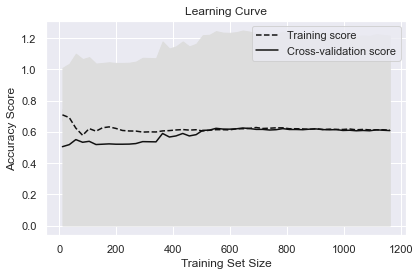

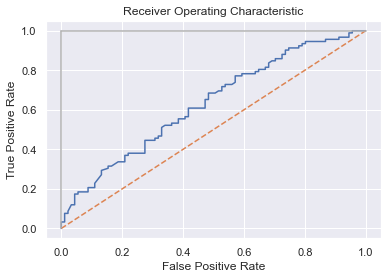

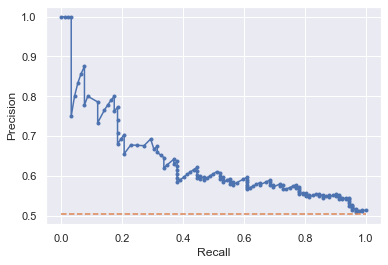

Best F1 score: 0.5714285714285713 Best threshold value: 0.1


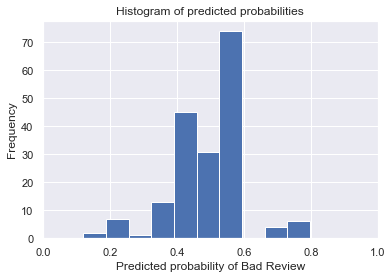

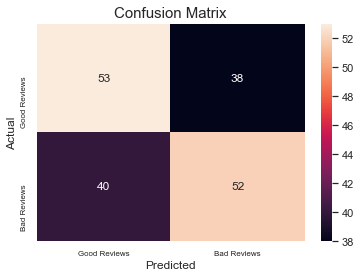

In [254]:
run_mod(nb,X_train,y_train)

In [255]:
nb_base = run_mod.results
nb_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.57377,0.573817,0.577778,0.565217,0.571429,0.567686,0.63157,0.636907


### Logistic Regression Classifier

              precision    recall  f1-score   support

           0       0.61      0.57      0.59        91
           1       0.60      0.64      0.62        92

    accuracy                           0.61       183
   macro avg       0.61      0.61      0.61       183
weighted avg       0.61      0.61      0.61       183



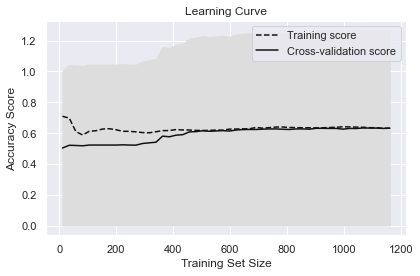

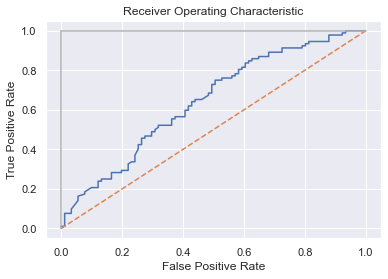

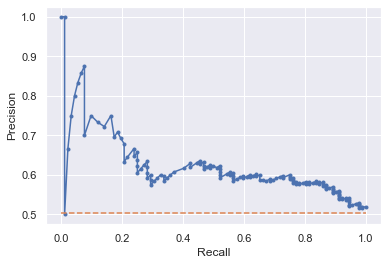

Best F1 score: 0.6210526315789474 Best threshold value: 0.1


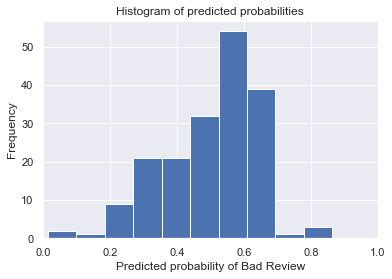

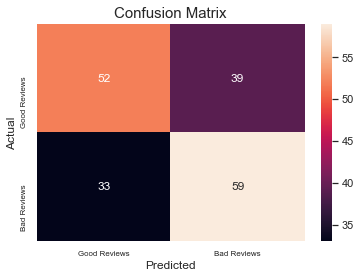

In [256]:
run_mod(lr,X_train,y_train)

In [257]:
lr_base = run_mod.results
lr_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.606557,0.606366,0.602041,0.641304,0.621053,0.633047,0.643036,0.625065


### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.60      0.55      0.57        91
           1       0.59      0.63      0.61        92

    accuracy                           0.59       183
   macro avg       0.59      0.59      0.59       183
weighted avg       0.59      0.59      0.59       183



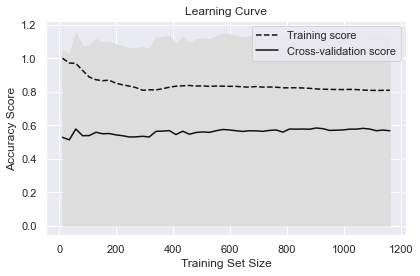

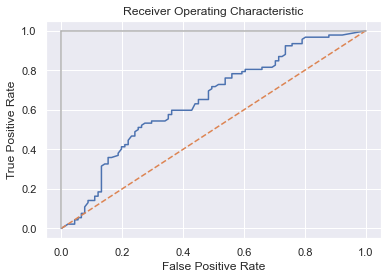

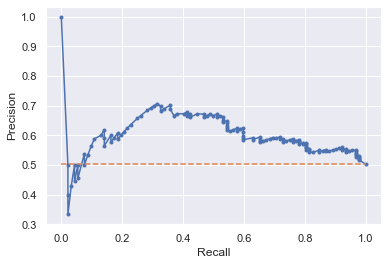

Best F1 score: 0.6073298429319373 Best threshold value: 0.1


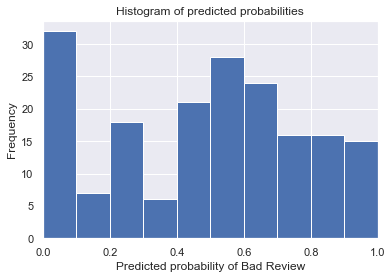

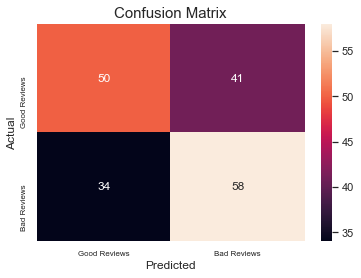

In [258]:
run_mod(rf,X_train,y_train)

In [259]:
rf_base = run_mod.results
rf_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.590164,0.589943,0.585859,0.630435,0.60733,0.620985,0.647516,0.604198


### Support Vector Machine Classifier 

              precision    recall  f1-score   support

           0       0.61      0.51      0.55        91
           1       0.58      0.67      0.62        92

    accuracy                           0.59       183
   macro avg       0.59      0.59      0.59       183
weighted avg       0.59      0.59      0.59       183



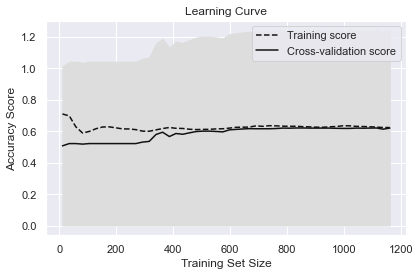

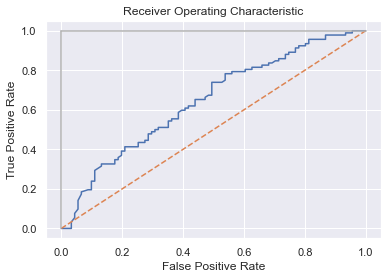

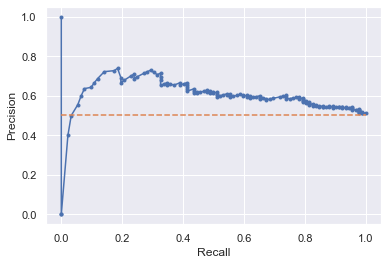

Best F1 score: 0.6231155778894473 Best threshold value: 0.1


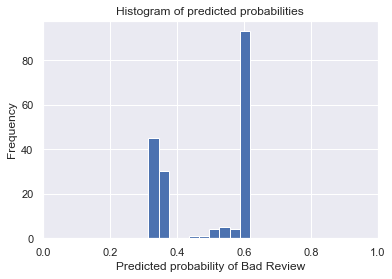

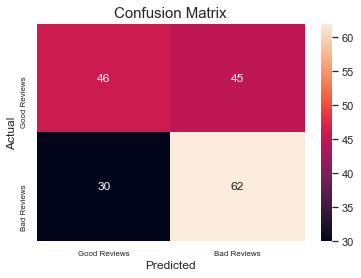

In [260]:
run_mod(svm,X_train,y_train)

In [261]:
svm_base = run_mod.results
svm_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.590164,0.589704,0.579439,0.673913,0.623116,0.652632,0.645246,0.606893


In [262]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector"]

training_summary = pd.concat([nb_base,lr_base,rf_base,svm_base])
training_summary.set_index([models],inplace = True)
training_summary

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
Multinomial NB,0.573770,0.573817,0.577778,0.565217,0.571429,0.567686,0.631570,0.636907
Logistic Regression,0.606557,0.606366,0.602041,0.641304,0.621053,0.633047,0.643036,0.625065
Random Forest,0.590164,0.589943,0.585859,0.630435,0.607330,0.620985,0.647516,0.604198
Support Vector,0.590164,0.589704,0.579439,0.673913,0.623116,0.652632,0.645246,0.606893
